### Importing Skin Cancer Data

### Importing all the important libraries

In [1]:
#Template https://www.tensorflow.org/tutorials/load_data/images


In [33]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [34]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [32]:
# !unzip /content/gdrive/MyDrive/EPGP_ML_AI/CNN-Assignment/CNN_assignment.zip -d /content/gdrive/MyDrive/EPGP_ML_AI/CNN-Assignment

Archive:  /content/gdrive/MyDrive/EPGP_ML_AI/CNN-Assignment/CNN_assignment.zip
  inflating: /content/gdrive/MyDrive/EPGP_ML_AI/CNN-Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0010512.jpg  
  inflating: /content/gdrive/MyDrive/EPGP_ML_AI/CNN-Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0010889.jpg  
  inflating: /content/gdrive/MyDrive/EPGP_ML_AI/CNN-Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024468.jpg  
  inflating: /content/gdrive/MyDrive/EPGP_ML_AI/CNN-Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024470.jpg  
  inflating: /content/gdrive/MyDrive/EPGP_ML_AI/CNN-Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024511.jpg  
  inflating: /content/gdrive/MyDrive/EPGP_ML_AI/CNN-Assignment/Skin cancer ISIC The In

In [35]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("/content/gdrive/MyDrive/EPGP_ML_AI/CNN-Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path('/content/gdrive/MyDrive/EPGP_ML_AI/CNN-Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Test')

In [36]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [37]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [38]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [39]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [40]:
# List out all the classes of skin cancer and store them in a list.
# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


In [41]:
print(type(train_ds))

<class 'tensorflow.python.data.ops.prefetch_op._PrefetchDataset'>


In [42]:
for images, labels in train_ds.take(1):
  print(len(images))
  print(len(labels))

32
32


32
32


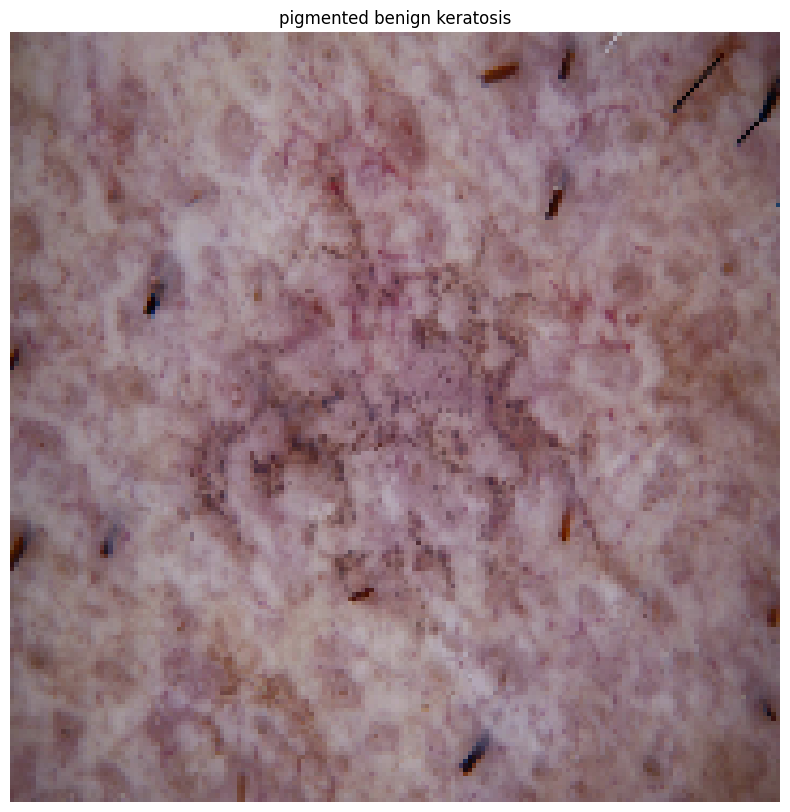

In [43]:

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  print(len(images))
  print(len(labels))
  plt.imshow(images[10].numpy().astype("uint8"))
  plt.title(class_names[labels[10]])
  plt.axis("off")


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

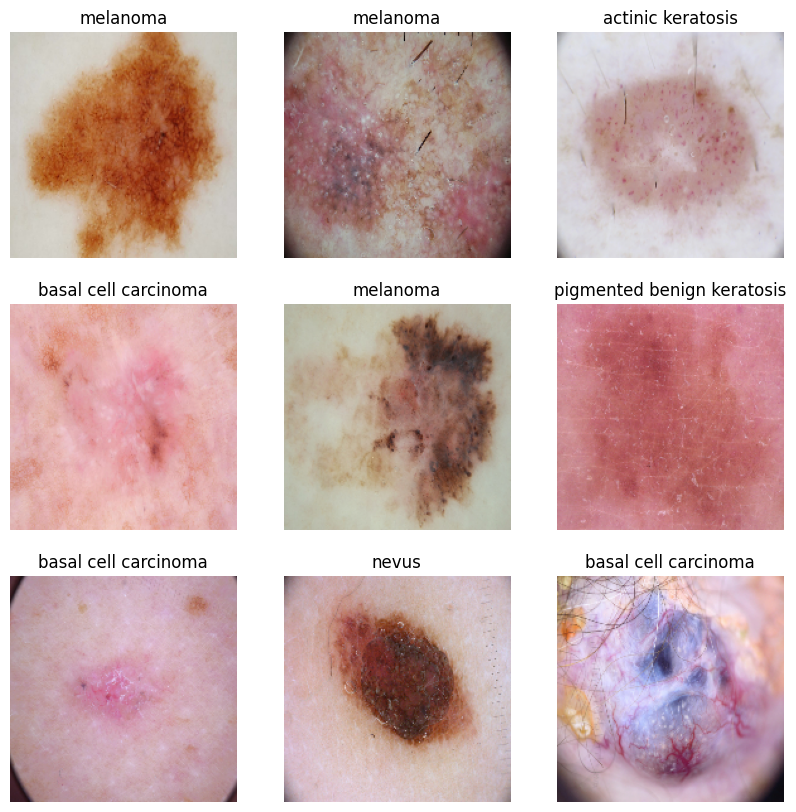

In [44]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(5):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

### your code goes here, you can use training or validation data to visualize

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [45]:
#overlaps data preprocessing and model execution while training., Speed up training
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model

## Model-1: Base Model

In [46]:
num_classes = 9

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])


### Compile the model
Choose an appropirate optimiser and loss function for model training

In [47]:
# View the summary of all layers
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_9 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 90, 90, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 45, 45, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_11 (Conv2D)          (None, 45, 45, 64)       

In [48]:
### Todo, choose an appropirate optimiser and loss function
#RMSprop. RMSprop is a very effective, but currently unpublished adaptive learning rate method
#Adam. Adam is a recently proposed update that looks a bit like RMSProp with momentum. The (simplified) update looks as follows:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [49]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 27s 133ms/step - loss: 2.0444 - accuracy: 0.2388 - val_loss: 1.8804 - val_accuracy: 0.3266
Epoch 2/20
56/56 [==============================] - 1s 22ms/step - loss: 1.6886 - accuracy: 0.3923 - val_loss: 1.8392 - val_accuracy: 0.3535
Epoch 3/20
56/56 [==============================] - 1s 21ms/step - loss: 1.4648 - accuracy: 0.4972 - val_loss: 1.4109 - val_accuracy: 0.4989
Epoch 4/20
56/56 [==============================] - 1s 22ms/step - loss: 1.3296 - accuracy: 0.5240 - val_loss: 1.4707 - val_accuracy: 0.5101
Epoch 5/20
56/56 [==============================] - 1s 21ms/step - loss: 1.2609 - accuracy: 0.5474 - val_loss: 1.4262 - val_accuracy: 0.5302
Epoch 6/20
56/56 [==============================] - 1s 21ms/step - loss: 1.2181 - accuracy: 0.5698 - val_loss: 1.4659 - val_accuracy: 0.5168
Epoch 7/20
56/56 [==============================] - 1s 21ms/step - loss: 1.1346 - accuracy: 0.6027 - val_loss: 1.3397 - val_accuracy: 0.5570
Epoch 8/20


### Train the model

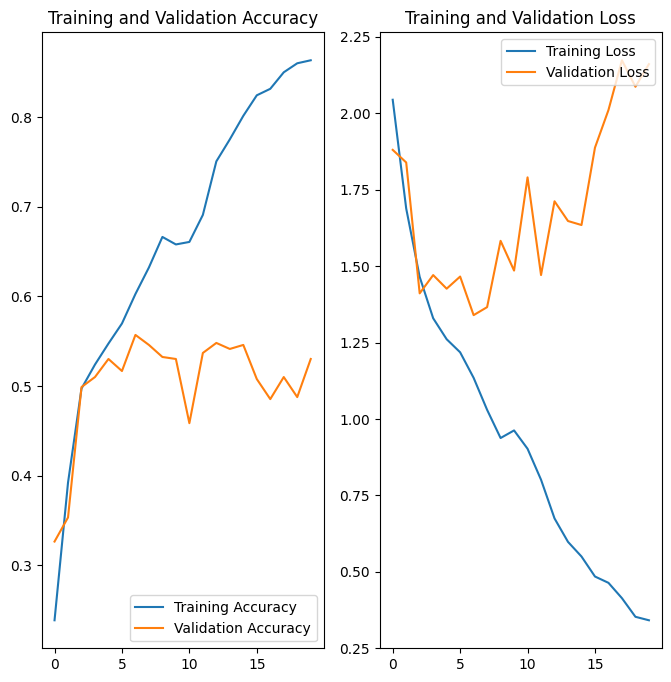

In [50]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

As we can see above as the number of epochs increases, the validation accuracy almost remains constant, but the training accuracy increases which means that the model is overfitting.

In the above model we used multiple convolution layers, let's start to decrease one CONV2D layer and see the effect.

## Model-2: Decreasing Convolution Layer

In [51]:
num_classes = 9

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])


In [52]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_4 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_12 (Conv2D)          (None, 180, 180, 64)      1792      
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 90, 90, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_13 (Conv2D)          (None, 90, 90, 128)       73856     
                                                                 
 max_pooling2d_13 (MaxPooli  (None, 45, 45, 128)       0         
 ng2D)                                                           
                                                                 
 conv2d_14 (Conv2D)          (None, 45, 45, 64)       

In [53]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [54]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 6s 83ms/step - loss: 2.0719 - accuracy: 0.1998 - val_loss: 2.0216 - val_accuracy: 0.1991
Epoch 2/20
56/56 [==============================] - 3s 61ms/step - loss: 1.9254 - accuracy: 0.2807 - val_loss: 1.7453 - val_accuracy: 0.4049
Epoch 3/20
56/56 [==============================] - 4s 64ms/step - loss: 1.6701 - accuracy: 0.3934 - val_loss: 1.5560 - val_accuracy: 0.4362
Epoch 4/20
56/56 [==============================] - 3s 61ms/step - loss: 1.4606 - accuracy: 0.4637 - val_loss: 1.4329 - val_accuracy: 0.4966
Epoch 5/20
56/56 [==============================] - 3s 62ms/step - loss: 1.3566 - accuracy: 0.5145 - val_loss: 1.4224 - val_accuracy: 0.5257
Epoch 6/20
56/56 [==============================] - 4s 63ms/step - loss: 1.2963 - accuracy: 0.5251 - val_loss: 1.4436 - val_accuracy: 0.5078
Epoch 7/20
56/56 [==============================] - 3s 61ms/step - loss: 1.2364 - accuracy: 0.5497 - val_loss: 1.5049 - val_accuracy: 0.5034
Epoch 8/20
56

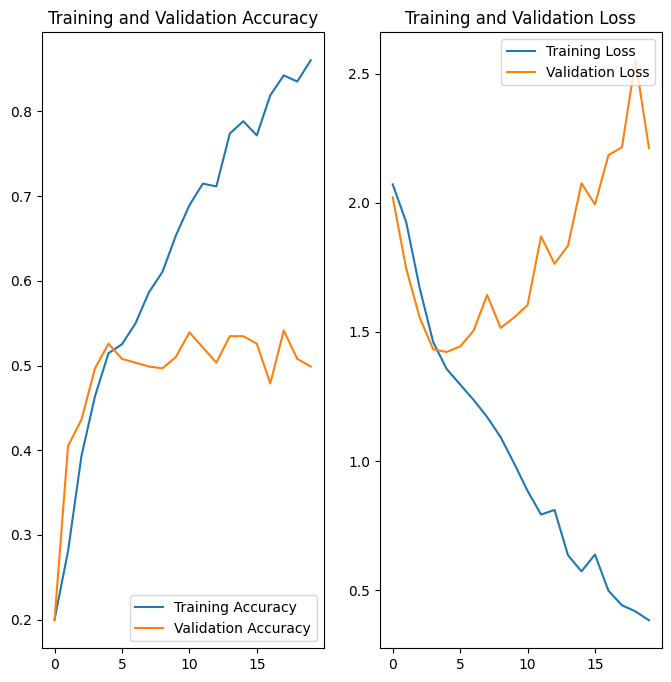

In [55]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Although we have decreased the Convolutional layers, the model still is overfitting the data as can be observed from the graph. The training accuracy is increasing although the validation accuracy is not increasing.

We try to introduce augmentation in the sequence to reduce overfitting.
There are many types of augmentations available but we will choose which are appropriate for the use case like flipping, rotation, zoom, crop

In [56]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy.
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal",
                                                 input_shape=(img_height,
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.15),
    layers.experimental.preprocessing.RandomZoom(0.1),
    layers.experimental.preprocessing.RandomTranslation(1,.5,fill_mode="reflect",interpolation="bilinear",seed=None,fill_value=0.0),
    layers.experimental.preprocessing.RandomCrop(img_height,img_width),
  ]
)

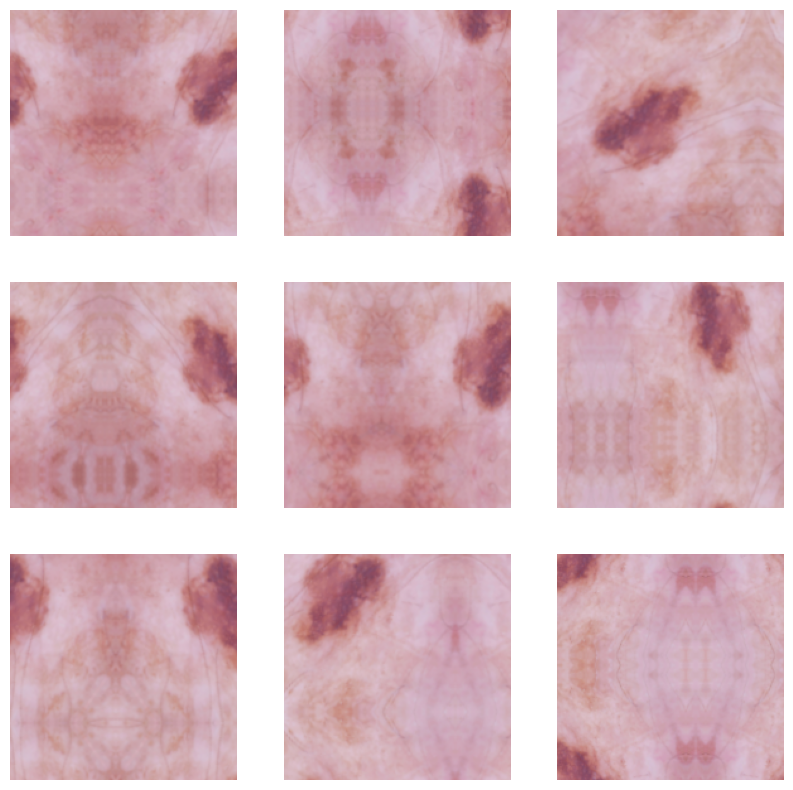

In [57]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

## Model-3: Base Model + Augmentation

In [58]:
num_classes = 9

model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(256, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])



In [59]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_6 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_5 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_15 (Conv2D)          (None, 180, 180, 64)      1792      
                                                                 
 max_pooling2d_15 (MaxPooli  (None, 90, 90, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_16 (Conv2D)          (None, 90, 90, 128)       73856     
                                                                 
 max_pooling2d_16 (MaxPooli  (None, 45, 45, 128)       0         
 ng2D)                                                

In [60]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [61]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 8s 92ms/step - loss: 2.1505 - accuracy: 0.2132 - val_loss: 1.9653 - val_accuracy: 0.2103
Epoch 2/20
56/56 [==============================] - 4s 79ms/step - loss: 1.9008 - accuracy: 0.3125 - val_loss: 1.7644 - val_accuracy: 0.3535
Epoch 3/20
56/56 [==============================] - 4s 78ms/step - loss: 1.7382 - accuracy: 0.3527 - val_loss: 1.6770 - val_accuracy: 0.3691
Epoch 4/20
56/56 [==============================] - 5s 88ms/step - loss: 1.7072 - accuracy: 0.3404 - val_loss: 1.6569 - val_accuracy: 0.3691
Epoch 5/20
56/56 [==============================] - 4s 78ms/step - loss: 1.6928 - accuracy: 0.3700 - val_loss: 1.7062 - val_accuracy: 0.3356
Epoch 6/20
56/56 [==============================] - 4s 78ms/step - loss: 1.6299 - accuracy: 0.3934 - val_loss: 1.6678 - val_accuracy: 0.3803
Epoch 7/20
56/56 [==============================] - 5s 87ms/step - loss: 1.5974 - accuracy: 0.4001 - val_loss: 1.5541 - val_accuracy: 0.4251
Epoch 8/20
56

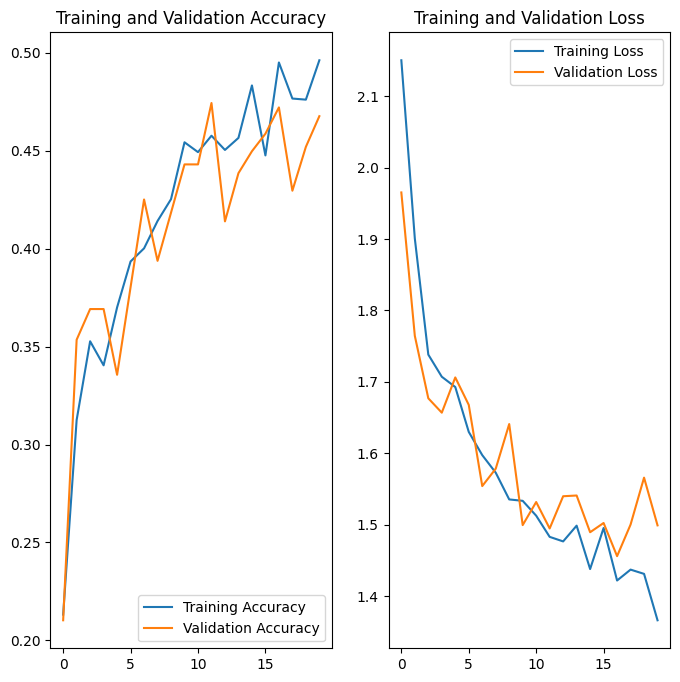

In [62]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Now we can see that the training and validation accuracy are co-inciding at times so lets try to refine the model by adding a dropout layer in between.

## Model-4: Base Model + Extra Conv2D layer + Augmentation + Dropout

In [63]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(256, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])



In [64]:
## Your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [65]:
## Your code goes here, note: train your model for 20 epochs
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 11s 94ms/step - loss: 1.9981 - accuracy: 0.2372 - val_loss: 1.7618 - val_accuracy: 0.3468
Epoch 2/20
56/56 [==============================] - 4s 66ms/step - loss: 1.8350 - accuracy: 0.2958 - val_loss: 1.7883 - val_accuracy: 0.3311
Epoch 3/20
56/56 [==============================] - 4s 64ms/step - loss: 1.7124 - accuracy: 0.3555 - val_loss: 1.6985 - val_accuracy: 0.3512
Epoch 4/20
56/56 [==============================] - 4s 65ms/step - loss: 1.6425 - accuracy: 0.3878 - val_loss: 1.7296 - val_accuracy: 0.3870
Epoch 5/20
56/56 [==============================] - 4s 65ms/step - loss: 1.7074 - accuracy: 0.3477 - val_loss: 1.7657 - val_accuracy: 0.3893
Epoch 6/20
56/56 [==============================] - 3s 62ms/step - loss: 1.5828 - accuracy: 0.4062 - val_loss: 1.5710 - val_accuracy: 0.4049
Epoch 7/20
56/56 [==============================] - 3s 62ms/step - loss: 1.6016 - accuracy: 0.4023 - val_loss: 1.8490 - val_accuracy: 0.3579
Epoch 8/20
5

### Visualizing the results

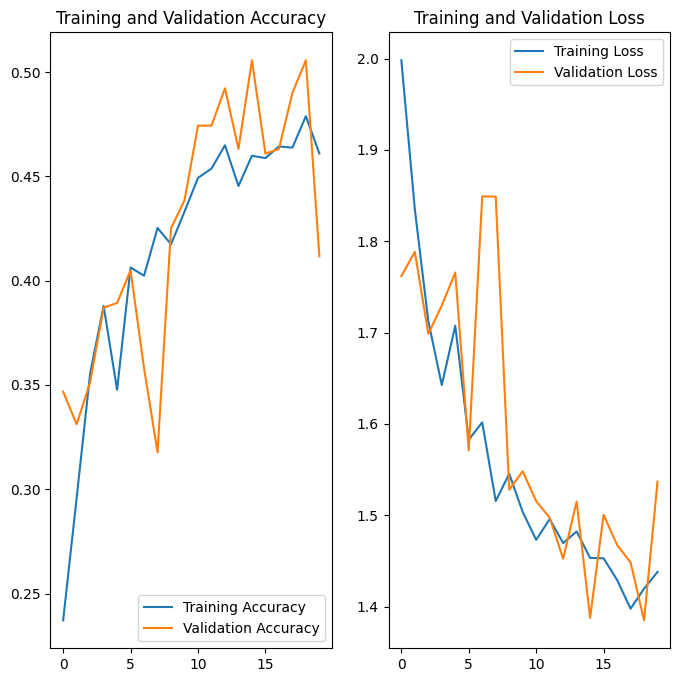

In [66]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

As we can see although increasing the Convolution Layers didn't increase the accuracy much.

Although it can be observed that the validation and training accuracy are nearly similar and there is no overfitting or underfitting observed.

But we need to try to increase the accuracies.

Let's try to observe the data imbalance if any present in the data.

In [67]:
# For convenience, let us set up the path for the training and validation sets
train_dir = os.path.join('/content/gdrive/MyDrive/EPGP_ML_AI/CNN-Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train')
test_dir = os.path.join('/content/gdrive/MyDrive/EPGP_ML_AI/CNN-Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Test')

Let's Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [72]:
## Your code goes here.
from glob import glob
path_list = [x for x in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
lesion_list = [os.path.basename(os.path.dirname(y)) for y in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
len(path_list)

2239

In [73]:
dataframe_dict_original = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
original_df

,Path,Label
0,/content/gdrive/MyDrive/EPGP_ML_AI/CNN-Assignm...,actinic keratosis
1,/content/gdrive/MyDrive/EPGP_ML_AI/CNN-Assignm...,actinic keratosis
2,/content/gdrive/MyDrive/EPGP_ML_AI/CNN-Assignm...,actinic keratosis
3,/content/gdrive/MyDrive/EPGP_ML_AI/CNN-Assignm...,actinic keratosis
4,/content/gdrive/MyDrive/EPGP_ML_AI/CNN-Assignm...,actinic keratosis
...,...,...
2234,/content/gdrive/MyDrive/EPGP_ML_AI/CNN-Assignm...,vascular lesion
2235,/content/gdrive/MyDrive/EPGP_ML_AI/CNN-Assignm...,vascular lesion
2236,/content/gdrive/MyDrive/EPGP_ML_AI/CNN-Assignm...,vascular lesion
2237,/content/gdrive/MyDrive/EPGP_ML_AI/CNN-Assignm...,vascular lesion


Class=actinic keratosis, n=114 (5.092%)
Class=basal cell carcinoma, n=376 (16.793%)
Class=dermatofibroma, n=95 (4.243%)
Class=melanoma, n=438 (19.562%)
Class=nevus, n=357 (15.945%)
Class=pigmented benign keratosis, n=462 (20.634%)
Class=seborrheic keratosis, n=77 (3.439%)
Class=squamous cell carcinoma, n=181 (8.084%)
Class=vascular lesion, n=139 (6.208%)


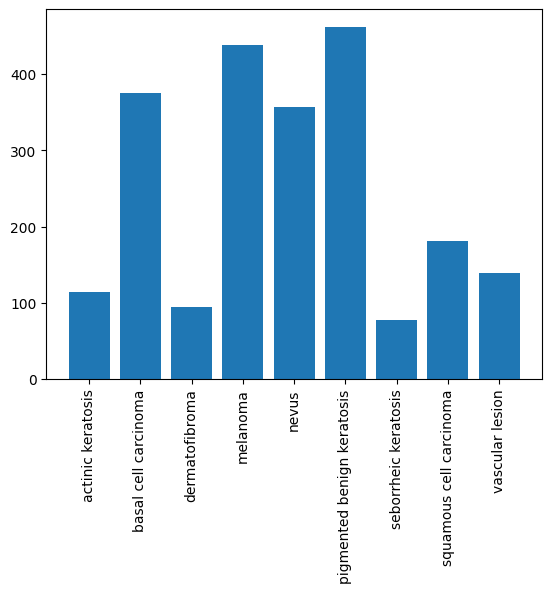

In [74]:
from sklearn.preprocessing import LabelEncoder
from collections import Counter
# split into input and output elements
X, y = original_df['Path'], original_df['Label']
# label encode the target variable
# y = LabelEncoder().fit_transform(y)
# summarize distribution
counter = Counter(y)
for k,v in counter.items():
	per = v / len(y) * 100
	print('Class=%s, n=%d (%.3f%%)' % (k, v, per))
# plot the distribution
plt.bar(counter.keys(), counter.values())
plt.xticks(rotation=90)
plt.show()

#### - As we can observe there is clearly class imbalance observed
#### - seborrheic keratosis class melanoma has very less data ~ 4% of the data only has this class of melanoma
#### - Whereas Pigmented Benign Keratosis has the highest data available ~ 20%.

We have to deal with the class imbalance.
One method suggested to deal with class imbalance is to add more samples which is achieved by using a Python package called as __Augmentor__

# Augmentor
We can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [75]:
!pip install Augmentor

In [76]:
import Augmentor

path_to_training_dataset='/content/gdrive/MyDrive/EPGP_ML_AI/CNN-Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/'

for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.zoom(probability=0.5, min_factor=1.1, max_factor=1.5)
    p.sample(500)
    p.process()

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/EPGP_ML_AI/CNN-Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7E714423B610>: 100%|██████████| 500/500 [00:34<00:00, 14.52 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7E7144208A00>: 100%|██████████| 114/114 [00:10<00:00, 11.23 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive/EPGP_ML_AI/CNN-Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7E71442F4460>: 100%|██████████| 500/500 [00:32<00:00, 15.42 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7E71443CF040>: 100%|██████████| 376/376 [00:18<00:00, 20.08 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/EPGP_ML_AI/CNN-Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7E7144313EB0>: 100%|██████████| 500/500 [00:25<00:00, 19.47 Samples/s]
Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7E7144220610>: 100%|██████████| 95/95 [00:04<00:00, 22.16 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/MyDrive/EPGP_ML_AI/CNN-Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7E7144221120>: 100%|██████████| 500/500 [01:57<00:00,  4.27 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7E71443CF7C0>: 100%|██████████| 438/438 [01:47<00:00,  4.06 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/EPGP_ML_AI/CNN-Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=767x576 at 0x7E71440FA410>: 100%|██████████| 500/500 [01:59<00:00,  4.19 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7E71443B1630>: 100%|██████████| 357/357 [01:19<00:00,  4.48 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/MyDrive/EPGP_ML_AI/CNN-Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7E71443B1750>: 100%|██████████| 500/500 [00:26<00:00, 18.91 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7E71443B0610>: 100%|██████████| 462/462 [00:23<00:00, 20.07 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/EPGP_ML_AI/CNN-Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7E71DBCB0640>: 100%|██████████| 500/500 [00:54<00:00,  9.21 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7E71D81C24D0>: 100%|██████████| 77/77 [00:10<00:00,  7.24 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/EPGP_ML_AI/CNN-Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7E71443B3C70>: 100%|██████████| 500/500 [00:23<00:00, 20.89 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7E714420BC10>: 100%|██████████| 181/181 [00:10<00:00, 17.75 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/EPGP_ML_AI/CNN-Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7E71442CF880>: 100%|██████████| 500/500 [00:25<00:00, 19.68 Samples/s]
Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7E7144109870>: 100%|██████████| 139/139 [00:07<00:00, 18.39 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [77]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

6739


### Lets see the distribution of augmented data after adding new images to the original training data.

In [79]:
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list_new

['/content/gdrive/MyDrive/EPGP_ML_AI/CNN-Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0027452.jpg_6a2576c2-0ec5-42ab-8c62-b5e74cc4c63f.jpg',
 '/content/gdrive/MyDrive/EPGP_ML_AI/CNN-Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0027829.jpg_fb6f0604-ae20-46fc-b4b0-e2af2b9cc346.jpg',
 '/content/gdrive/MyDrive/EPGP_ML_AI/CNN-Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0033811.jpg_53405d43-a983-4838-9fb2-f7e51a766897.jpg',
 '/content/gdrive/MyDrive/EPGP_ML_AI/CNN-Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0033494.jpg_7bc8c79d-3e88-4295-8a1b-126a230dc969.jpg',
 '/content/gdrive/MyDrive/EPGP_ML_AI/CNN-Assignment/Skin cancer ISIC The

In [80]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic 

In [81]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [82]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = original_df.append(df2)

<ipython-input-82-17a6b079869a>:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = original_df.append(df2)


In [83]:
new_df['Label'].value_counts()

pigmented benign keratosis    1424
melanoma                      1376
basal cell carcinoma          1252
nevus                         1214
squamous cell carcinoma        862
vascular lesion                778
actinic keratosis              728
dermatofibroma                 690
seborrheic keratosis           654
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

In [84]:
batch_size = 32
img_height = 180
img_width = 180

In [85]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training', ## Todo choose the correct parameter value, so that only training data is refered to
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 8978 files belonging to 9 classes.
Using 7183 files for training.


In [86]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',## Todo choose the correct parameter value, so that only validation data is refered to,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 8978 files belonging to 9 classes.
Using 1795 files for validation.


## Model-5: Model after Data Augmentation

In [87]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [88]:
## your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [89]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
225/225 [==============================] - 69s 89ms/step - loss: 1.7367 - accuracy: 0.3524 - val_loss: 1.4414 - val_accuracy: 0.4797
Epoch 2/20
225/225 [==============================] - 7s 29ms/step - loss: 1.3670 - accuracy: 0.4964 - val_loss: 1.2395 - val_accuracy: 0.5393
Epoch 3/20
225/225 [==============================] - 6s 29ms/step - loss: 1.1926 - accuracy: 0.5528 - val_loss: 1.1486 - val_accuracy: 0.5772
Epoch 4/20
225/225 [==============================] - 7s 31ms/step - loss: 1.0112 - accuracy: 0.6252 - val_loss: 0.9938 - val_accuracy: 0.6429
Epoch 5/20
225/225 [==============================] - 6s 29ms/step - loss: 0.8768 - accuracy: 0.6774 - val_loss: 0.9932 - val_accuracy: 0.6563
Epoch 6/20
225/225 [==============================] - 7s 30ms/step - loss: 0.7224 - accuracy: 0.7305 - val_loss: 0.8530 - val_accuracy: 0.6925
Epoch 7/20
225/225 [==============================] - 6s 29ms/step - loss: 0.6058 - accuracy: 0.7768 - val_loss: 0.8116 - val_accuracy: 0.733

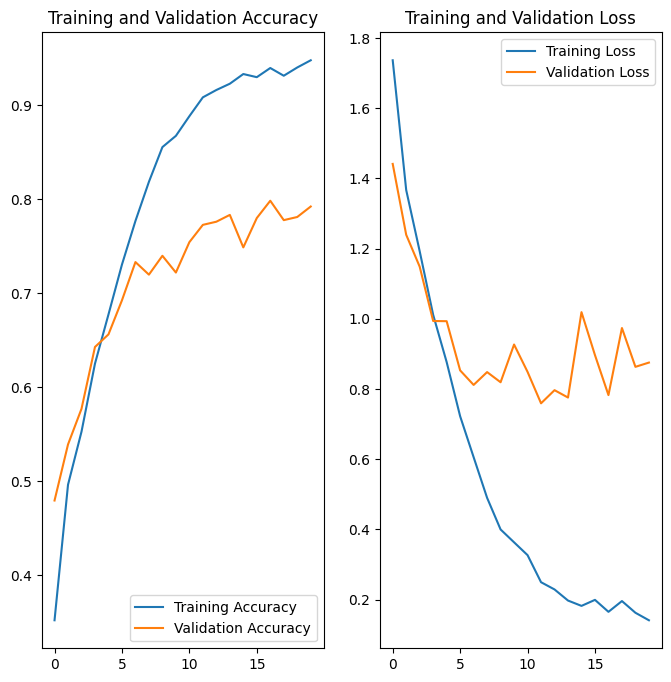

In [90]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

After Augmenting data using the python library, the accuracy of both Training and validation have increased significantly and we can observe that the model be slightly overfitting although after introducing dropouts.

But if we have to consider from the models trained so far, this model has given far better accuracies of both training & validation.

__Training accuracy__ =0.92

__Validation accuracy__ = 0.79

Let's also try to calculate the accuracy on test dataset.


In [91]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_test,
  seed=123,
  # validation_split = 0.2,
  # subset = 'validation',## Todo choose the correct parameter value, so that only validation data is refered to,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 118 files belonging to 9 classes.


In [92]:
test_loss, test_accuracy = model.evaluate(test_ds)

4/4 [==============================] - 5s 107ms/step - loss: 7.6493 - accuracy: 0.3898


Here, we can see the test accuracy __0.39__ is not so good as we expected it to be.

There are few more ways to train the model by introducing dropouts in the other dense layer as well, adding one more convolution layer (Although it might again lead to overfitting).

Also we can use transfer learning models for this dataset. All in all, if we have a little bit more data on hand, might give us better accuracy.